![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics


In [ ]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

In [ ]:
## Analisis de comentarios
tweets.iloc[26]["text"]

"@VirginAmerica What happened 2 ur vegan food options?! At least say on ur site so i know I won't be able 2 eat anything for next 6 hrs #fail"

### Análisis descriptivo

In [ ]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

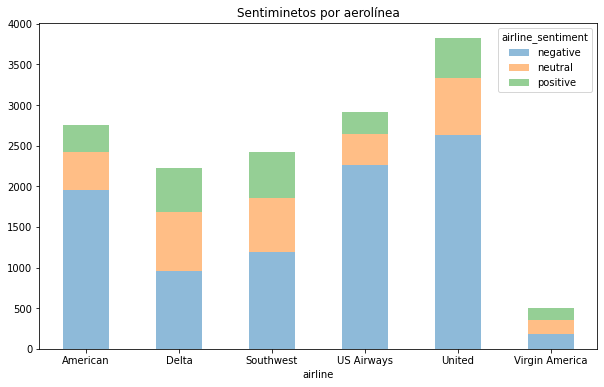

In [ ]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
import re
import nltk

In [ ]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [ ]:
X

tweet_id
570306133677760513                  @VirginAmerica What @dhepburn said.
570301130888122368    @VirginAmerica plus you've added commercials t...
570301083672813571    @VirginAmerica I didn't today... Must mean I n...
570301031407624196    @VirginAmerica it's really aggressive to blast...
570300817074462722    @VirginAmerica and it's a really big bad thing...
                                            ...                        
569587686496825344    @AmericanAir thank you we got on a different f...
569587371693355008    @AmericanAir leaving over 20 minutes Late Flig...
569587242672398336    @AmericanAir Please bring American Airlines to...
569587188687634433    @AmericanAir you have my money, you change my ...
569587140490866689    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [ ]:
y

tweet_id
570306133677760513    0
570301130888122368    1
570301083672813571    0
570301031407624196   -1
570300817074462722   -1
                     ..
569587686496825344    1
569587371693355008   -1
569587242672398336    0
569587188687634433   -1
569587140490866689    0
Name: airline_sentiment, Length: 14640, dtype: int64

In [ ]:
y.value_counts() ## Se observa que las clases estan desbalanceadas y que la mayoria de comentarios pertenecen a la clase negativa

-1    9178
 0    3099
 1    2363
Name: airline_sentiment, dtype: int64

In [ ]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
x_train= X_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)
x_test = X_test.values.reshape(-1, 1)

In [ ]:
### RandomUnderSampling
from imblearn.under_sampling import RandomUnderSampler

undersampling =RandomUnderSampler(random_state=42)
X_train_undersampling, y_train_undersampling = undersampling.fit_resample(x_train, y_train)  

Text(0, 0.5, 'Number of Observations')

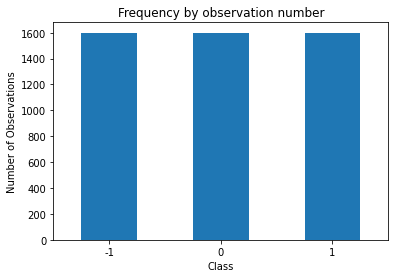

In [ ]:
count_classes = pd.value_counts(y_train_undersampling, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations") 

Se observa que cada clase , realizando RandomUnderSampler tiene 1600 observaciones

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

A continuación se crea la función "preprocessor" que se usará en los cuatro puntos. Esta función elimina los caracteres especiales, los números, URL, emojis, convierte el texto a minusculas y además quita los espacios en blanco que hayan tanto adelante como atrás del texto

In [ ]:
def preprocessor(text):
    
    text=re.sub("\W+"," ",str(text)) # caracteres especiales
    text=re.sub(" \d+", " ",str(text)) # eliminar numeros  
    text=text.lower() ##Texto a minusculas
    text = re.sub(r'^https?:\/\/.*[\r\n]*',"", str(text), flags=re.MULTILINE) ##Eliminar URL
    
    ##Eliminar emojis
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text=re.sub(emoj,"", str(text))
    text=text.strip() ## Eliminar espacios adelante y atras de un texto
    return text



In [ ]:
# Crear matrices y tokenización con limpieza de mayúsculas y acentos 
matriz = CountVectorizer(lowercase=False,strip_accents="unicode",preprocessor=preprocessor) 
XTrain_matriz = matriz.fit_transform(X_train_undersampling)
XTest_matriz = matriz.transform(X_test)

In [ ]:
# Impresión dimensiones de matriz
XTrain_matriz.shape

(4800, 7372)

Se tienen un total de 4.800 registros en el conjunto de entrenamiento y 7.372 tokens (unigramas). Ahora se visualiza el diccionario de palabras

In [ ]:
# Visualización de diccionario de palabras
matriz.vocabulary_

{'united': 6776,
 'u200b': 6663,
 'has': 2844,
 'cancelled': 948,
 'flighted': 2373,
 'arrival': 398,
 'into': 3253,
 'shv': 5802,
 'tonight': 6499,
 'amp': 273,
 'the': 6361,
 'st': 6034,
 'departure': 1661,
 'flight': 2363,
 'on': 4508,
 'mon': 4126,
 'feb': 2272,
 'rd': 5201,
 'check': 1099,
 'with': 7161,
 'your': 7317,
 'airline': 181,
 'for': 2451,
 'status': 6064,
 'virginamerica': 6943,
 'and': 284,
 'now': 4410,
 'booking': 773,
 'problems': 5020,
 'site': 5836,
 'is': 3285,
 'totally': 6512,
 'down': 1855,
 'folks': 2441,
 'what': 7085,
 'problem': 5019,
 'jetblue': 3360,
 'it': 3296,
 'physically': 4812,
 'impossible': 3124,
 'to': 6480,
 'make': 3874,
 'airport': 189,
 'our': 4590,
 'scheduled': 5629,
 'leave': 3614,
 'in': 3135,
 'less': 3635,
 'than': 6343,
 'hours': 3016,
 'usairways': 6845,
 'you': 7313,
 'should': 5784,
 'be': 605,
 'prepared': 4977,
 'weather': 7047,
 'all': 217,
 'want': 7010,
 'do': 1820,
 'find': 2320,
 'out': 4593,
 'if': 3092,
 'can': 944,
 'take

In [ ]:
# Visualización de  términos en el diccionario de palabras
print(matriz.get_feature_names())

['_0', '__rwg__', '_austrian', '_defcon_', 'a1', 'a1choxkpjp', 'a20', 'a3', 'a320', 'a37n3ohokl', 'a380s', 'a3ycflalxv', 'a587cw', 'a68d5fulmh', 'a7nvbj8ipx', 'aa', 'aa1401', 'aa1457', 'aa1469', 'aa153', 'aa1679', 'aa199', 'aa223', 'aa3074', 'aa375', 'aa45', 'aa5', 'aa65', 'aa67', 'aa76', 'aa973', 'aaadvantage', 'aaalwayslate', 'aadavantage', 'aadv', 'aadvantage', 'aafail', 'aateam', 'aavvoreph', 'aay5avg99b', 'abassinet', 'abc', 'abcnetwork', 'abcnews', 'abilities', 'ability', 'able', 'aboard', 'abounds', 'about', 'above', 'abq', 'absolute', 'absolutely', 'absoulutely', 'absurd', 'abt', 'abundance', 'abysmal', 'acc', 'accept', 'acceptable', 'accepted', 'accepting', 'access', 'accessible', 'accident', 'accidentally', 'accidents', 'accomidating', 'accommodate', 'accommodating', 'accommodation', 'accommodations', 'accomplished', 'according', 'accordingly', 'account', 'accountability', 'accounts', 'accrue', 'acct', 'accts', 'accumulation', 'accurate', 'achieves', 'acknowledgement', 'ackno

Se procede a usar un Random Forest para entrenar el modelo

In [ ]:
## Entrenar el modelo y la prediccion
rf_classifier= RandomForestClassifier()

In [ ]:
pd.Series(cross_val_score(rf_classifier, XTrain_matriz, y_train_undersampling, cv=10,scoring="accuracy")).describe()

count    10.000000
mean      0.717708
std       0.026192
min       0.668750
25%       0.700521
50%       0.722917
75%       0.731250
max       0.758333
dtype: float64

Se observa que el valor promedio del accuracy es del 71.77%. Ahora se calcula el desempeño del modelo usando el conjunto de prueba

In [ ]:
rf_classifier.fit(XTrain_matriz,y_train_undersampling)
prediccion_rf=rf_classifier.predict(XTest_matriz)

In [ ]:
## Calcular el accuracy
accuracy1 =accuracy_score(y_test, prediccion_rf)
print("Accuracy:",accuracy1)

Accuracy: 0.7024006622516556


Como se observa la métrica de desempeño arroja un accuracy del 70.24% 

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Crear matrices y tokenización con limpieza de mayúsculas ,acentos y eliminar stopwords
matriz_2 = CountVectorizer(lowercase=False,strip_accents="unicode",stop_words='english',preprocessor=preprocessor) 
XTrain_matriz_2 = matriz_2.fit_transform(X_train_undersampling)
XTest_matriz_2 = matriz_2.transform(X_test)


In [ ]:
# Impresión dimensiones de matriz
XTrain_matriz_2.shape

(4800, 7106)

Se tienen un total de 4.800 registros en el conjunto de entrenamiento y un total de 7.106 tokens. Ahora se procede a observar los stopwords del texto

In [ ]:
# Impresión de stopwords del texto
## Se pasa a una lista

stop_words=list(matriz_2.get_stop_words())
stop_words

['being',
 'much',
 'she',
 'before',
 'perhaps',
 'after',
 'or',
 'nobody',
 'therefore',
 'am',
 'eg',
 'thereafter',
 'towards',
 'amoungst',
 'fifteen',
 'because',
 'such',
 'others',
 'both',
 'herself',
 'can',
 'move',
 'beside',
 'made',
 'only',
 'cry',
 'up',
 'the',
 'eleven',
 'hers',
 'interest',
 'some',
 'his',
 'wherever',
 'go',
 'without',
 'five',
 'among',
 'show',
 'former',
 'take',
 'from',
 'with',
 'otherwise',
 'should',
 'ever',
 'our',
 'thru',
 'anything',
 'none',
 'across',
 'when',
 'about',
 'anyhow',
 'no',
 'still',
 'a',
 'if',
 'do',
 'against',
 'sixty',
 'are',
 'everyone',
 'also',
 'ours',
 'ltd',
 'whom',
 'itself',
 'whole',
 'within',
 'three',
 'as',
 'anywhere',
 'whenever',
 'herein',
 'nine',
 'side',
 'name',
 'would',
 'somehow',
 'someone',
 'get',
 'however',
 'behind',
 'other',
 'an',
 'few',
 'myself',
 'it',
 'never',
 'during',
 'inc',
 'third',
 'couldnt',
 'beyond',
 'top',
 'yours',
 'while',
 'amongst',
 'whereafter',
 'ie'

Al analizar los stopwords se evidencia que se eliminan palabras como "no","couldnt","cannot" ,"hasnt", y "not"  que pueden modificar completamente el significado de la oración. Por lo tanto se modificará la anterior lista de stopwords eliminando las palabras anteriormente mencionadas

In [ ]:
elementos=["hasnt","no","cannot","couldnt","not"]

for i in elementos:
  stop_words.remove(i)


In [ ]:
# Crear matrices y tokenización con limpieza de mayúsculas ,acentos y eliminar stopwords(modificados)
matriz_3= CountVectorizer(lowercase=False,strip_accents="unicode",stop_words=stop_words,preprocessor=preprocessor) 
XTrain_matriz_3= matriz_3.fit_transform(X_train_undersampling)
XTest_matriz_3= matriz_3.transform(X_test)

In [ ]:
# Impresión dimensiones de matriz
XTrain_matriz_3.shape

(4800, 7110)

Se tienen un total de 4.800 registros en el conjunto de entrenamiento y 7.110 tokens

In [ ]:
# Visualización de diccionario de palabras
matriz_3.vocabulary_

{'united': 6550,
 'u200b': 6438,
 'cancelled': 897,
 'flighted': 2289,
 'arrival': 370,
 'shv': 5620,
 'tonight': 6279,
 'amp': 255,
 'st': 5840,
 'departure': 1605,
 'flight': 2279,
 'mon': 3996,
 'feb': 2194,
 'rd': 5030,
 'check': 1047,
 'airline': 175,
 'status': 5870,
 'virginamerica': 6711,
 'booking': 728,
 'problems': 4851,
 'site': 5651,
 'totally': 6290,
 'folks': 2357,
 'problem': 4850,
 'jetblue': 3241,
 'physically': 4644,
 'impossible': 3014,
 'make': 3750,
 'airport': 183,
 'scheduled': 5456,
 'leave': 3492,
 'hours': 2910,
 'usairways': 6615,
 'prepared': 4808,
 'weather': 6813,
 'want': 6778,
 'train': 6312,
 'phl': 4630,
 'catch': 955,
 'connection': 1295,
 'wanted': 6779,
 'bag': 526,
 'benefit': 611,
 'instead': 3112,
 'pricing': 4830,
 'tickets': 6218,
 'adding': 102,
 'card': 922,
 'mp': 4024,
 'visa': 6714,
 'option': 4394,
 'sitting': 5655,
 'rude': 5355,
 'customer': 1455,
 'service': 5549,
 'agents': 146,
 'perfectomobile': 4593,
 'huh': 2932,
 'sent': 5538,
 

In [ ]:
# Visualización de  términos en el diccionario de palabras
print(matriz_3.get_feature_names())

['_0', '__rwg__', '_austrian', '_defcon_', 'a1', 'a1choxkpjp', 'a20', 'a3', 'a320', 'a37n3ohokl', 'a380s', 'a3ycflalxv', 'a587cw', 'a68d5fulmh', 'a7nvbj8ipx', 'aa', 'aa1401', 'aa1457', 'aa1469', 'aa153', 'aa1679', 'aa199', 'aa223', 'aa3074', 'aa375', 'aa45', 'aa5', 'aa65', 'aa67', 'aa76', 'aa973', 'aaadvantage', 'aaalwayslate', 'aadavantage', 'aadv', 'aadvantage', 'aafail', 'aateam', 'aavvoreph', 'aay5avg99b', 'abassinet', 'abc', 'abcnetwork', 'abcnews', 'abilities', 'ability', 'able', 'aboard', 'abounds', 'abq', 'absolute', 'absolutely', 'absoulutely', 'absurd', 'abt', 'abundance', 'abysmal', 'acc', 'accept', 'acceptable', 'accepted', 'accepting', 'access', 'accessible', 'accident', 'accidentally', 'accidents', 'accomidating', 'accommodate', 'accommodating', 'accommodation', 'accommodations', 'accomplished', 'according', 'accordingly', 'account', 'accountability', 'accounts', 'accrue', 'acct', 'accts', 'accumulation', 'accurate', 'achieves', 'acknowledgement', 'acknowledgment', 'act',

In [ ]:
pd.Series(cross_val_score(rf_classifier, XTrain_matriz_3, y_train_undersampling, cv=10,scoring="accuracy")).describe()

count    10.000000
mean      0.700417
std       0.025303
min       0.650000
25%       0.691667
50%       0.701042
75%       0.720313
max       0.731250
dtype: float64

Se observa que el valor promedio del accuracy es 70.04%, es un valor menor al anteriormente presentado. Ahora se calcula el desempeño del modelo usando el conjunto de prueba

In [ ]:
rf_classifier.fit(XTrain_matriz_3,y_train_undersampling)
prediccion_rf_2=rf_classifier.predict(XTest_matriz_3)

In [ ]:
## Calcular el accuracy
accuracy2 =accuracy_score(y_test, prediccion_rf_2)
print("Accuracy:",accuracy2)

Accuracy: 0.6759105960264901


Como se observa la métrica de desempeño arroja un accuracy del 67.59%

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Importación de librerias
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Creación de matrices de documentos usando CountVectorizer
matriz_doc = CountVectorizer(lowercase=False,strip_accents="unicode",preprocessor=preprocessor)
matriz_doc.fit(X_train_undersampling)

CountVectorizer(lowercase=False,
                preprocessor=<function preprocessor at 0x7f2142f7db90>,
                strip_accents='unicode')

In [ ]:
# Definiicón de lista con vocabulario de la matriz de documentos
words = list(matriz_doc.vocabulary_.keys())
words

['united',
 'u200b',
 'has',
 'cancelled',
 'flighted',
 'arrival',
 'into',
 'shv',
 'tonight',
 'amp',
 'the',
 'st',
 'departure',
 'flight',
 'on',
 'mon',
 'feb',
 'rd',
 'check',
 'with',
 'your',
 'airline',
 'for',
 'status',
 'virginamerica',
 'and',
 'now',
 'booking',
 'problems',
 'site',
 'is',
 'totally',
 'down',
 'folks',
 'what',
 'problem',
 'jetblue',
 'it',
 'physically',
 'impossible',
 'to',
 'make',
 'airport',
 'our',
 'scheduled',
 'leave',
 'in',
 'less',
 'than',
 'hours',
 'usairways',
 'you',
 'should',
 'be',
 'prepared',
 'weather',
 'all',
 'want',
 'do',
 'find',
 'out',
 'if',
 'can',
 'take',
 'train',
 'phl',
 'catch',
 'my',
 'connection',
 'wanted',
 'get',
 'bag',
 'benefit',
 'but',
 'instead',
 'pricing',
 'three',
 'tickets',
 'when',
 'adding',
 'card',
 'mp',
 'visa',
 'only',
 'option',
 'sitting',
 'here',
 'of',
 'rude',
 'customer',
 'service',
 'agents',
 'perfectomobile',
 'huh',
 'have',
 'sent',
 'crash',
 'reports',
 'alone',
 'one',

In [ ]:
# Obtención e impresión de los lemas de cada palabra de la lista asumiendo que cada palabra es un verbo
print([wordnet_lemmatizer.lemmatize(word,pos='v') for word in words])

['unite', 'u200b', 'have', 'cancel', 'flight', 'arrival', 'into', 'shv', 'tonight', 'amp', 'the', 'st', 'departure', 'flight', 'on', 'mon', 'feb', 'rd', 'check', 'with', 'your', 'airline', 'for', 'status', 'virginamerica', 'and', 'now', 'book', 'problems', 'site', 'be', 'totally', 'down', 'folks', 'what', 'problem', 'jetblue', 'it', 'physically', 'impossible', 'to', 'make', 'airport', 'our', 'schedule', 'leave', 'in', 'less', 'than', 'hours', 'usairways', 'you', 'should', 'be', 'prepare', 'weather', 'all', 'want', 'do', 'find', 'out', 'if', 'can', 'take', 'train', 'phl', 'catch', 'my', 'connection', 'want', 'get', 'bag', 'benefit', 'but', 'instead', 'price', 'three', 'ticket', 'when', 'add', 'card', 'mp', 'visa', 'only', 'option', 'sit', 'here', 'of', 'rude', 'customer', 'service', 'agents', 'perfectomobile', 'huh', 'have', 'send', 'crash', 'report', 'alone', 'one', 'day', 'app', 'that', 'consistently', 'crash', 'southwestair', 'why', 'guy', 'jack', 'up', 'price', 'after', 'say', 'be',

Para crear los lemas se crea una función donde se convierta el texto a minúscula y se eliminen caracteres especiales, números, URL y emojis

In [ ]:
# Definición de la función que tenga como parámetro texto y devuelva una lista de lemas (esto se modifico)
def split_into_lemmas(text):
  text=re.sub("\W+"," ",str(text)) # caracteres especiales
  text=re.sub(" \d+", " ",str(text)) # eliminar numeros  
  text=text.lower() ##Texto a minusculas
  text = re.sub(r'^https?:\/\/.*[\r\n]*',"", str(text), flags=re.MULTILINE) ##Eliminar URL
    
  ##Eliminar emojis
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
  text=re.sub(emoj,"", str(text))
  text=text.strip() ## Eliminar espacios adelante y atras de un texto
  words = text.split()
  return [wordnet_lemmatizer.lemmatize(word,pos='v') for word in words]

In [ ]:
# Crear matrices y tokenización con limpieza de mayúsculas ,acentos y eliminar stopwords
matriz_4 = CountVectorizer(lowercase=False,strip_accents="unicode",analyzer=split_into_lemmas,preprocessor=preprocessor) 
XTrain_matriz_4= matriz_4.fit_transform(X_train_undersampling)
XTest_matriz_4= matriz_4.transform(X_test)


In [ ]:
# Impresión dimensiones de matriz
XTrain_matriz_4.shape

(4800, 6454)

Se tienen un total de 4.800 registros en el conjunto de entrenamiento y 6.454 tokens, es un número menor a los casos anteriores

In [ ]:
# Visualización de diccionario de palabras
matriz_4.vocabulary_

{'unite': 5909,
 'u200b': 5800,
 'have': 2495,
 'cancel': 844,
 'flight': 2052,
 'arrival': 357,
 'into': 2853,
 'shv': 5069,
 'tonight': 5665,
 'amp': 250,
 'the': 5543,
 'st': 5263,
 'departure': 1443,
 'on': 3997,
 'mon': 3631,
 'feb': 1979,
 'rd': 4593,
 'check': 964,
 'with': 6254,
 'your': 6397,
 'airline': 165,
 'for': 2130,
 'status': 5285,
 'virginamerica': 6062,
 'and': 261,
 'now': 3902,
 'book': 689,
 'problems': 4438,
 'site': 5098,
 'be': 544,
 'totally': 5678,
 'down': 1612,
 'folks': 2123,
 'what': 6185,
 'problem': 4437,
 'jetblue': 2956,
 'it': 2891,
 'physically': 4268,
 'impossible': 2740,
 'to': 5648,
 'make': 3407,
 'airport': 173,
 'our': 4073,
 'schedule': 4937,
 'leave': 3189,
 'in': 2748,
 'less': 3206,
 'than': 5527,
 'hours': 2637,
 'usairways': 5971,
 'you': 6393,
 'should': 5055,
 'prepare': 4404,
 'weather': 6154,
 'all': 200,
 'i': 2684,
 'want': 6125,
 'do': 1581,
 'find': 2017,
 'out': 4076,
 'if': 2710,
 'can': 840,
 'take': 5465,
 'train': 5695,
 'ph

In [ ]:
# Visualización de  términos en el diccionario de palabras
print(matriz_4.get_feature_names())

['_', '_0', '__rwg__', '_austrian', '_defcon_', 'a', 'a1', 'a1choxkpjp', 'a20', 'a3', 'a320', 'a37n3ohokl', 'a380s', 'a3ycflalxv', 'a587cw', 'a68d5fulmh', 'a7nvbj8ipx', 'aa', 'aa1401', 'aa1457', 'aa1469', 'aa153', 'aa1679', 'aa199', 'aa223', 'aa3074', 'aa375', 'aa45', 'aa5', 'aa65', 'aa67', 'aa76', 'aa973', 'aaadvantage', 'aaalwayslate', 'aadavantage', 'aadv', 'aadvantage', 'aafail', 'aateam', 'aavvoreph', 'aay5avg99b', 'abassinet', 'abc', 'abcnetwork', 'abcnews', 'abilities', 'ability', 'able', 'aboard', 'abound', 'about', 'above', 'abq', 'absolute', 'absolutely', 'absoulutely', 'absurd', 'abt', 'abundance', 'abysmal', 'acc', 'accept', 'acceptable', 'access', 'accessible', 'accident', 'accidentally', 'accidents', 'accomidating', 'accommodate', 'accommodation', 'accommodations', 'accomplish', 'accord', 'accordingly', 'account', 'accountability', 'accrue', 'acct', 'accts', 'accumulation', 'accurate', 'achieve', 'acknowledgement', 'acknowledgment', 'across', 'act', 'action', 'activate', 

In [ ]:
pd.Series(cross_val_score(rf_classifier, XTrain_matriz_4, y_train_undersampling, cv=10,scoring="accuracy")).describe()

count    10.000000
mean      0.719583
std       0.023879
min       0.677083
25%       0.708854
50%       0.719792
75%       0.739583
max       0.747917
dtype: float64

Se observa que el valor promedio del accuracy es 71.95% .Ahora se calcula el desempeño del modelo usando el conjunto de prueba

In [ ]:
rf_classifier.fit(XTrain_matriz_4,y_train_undersampling)
prediccion_rf_3=rf_classifier.predict(XTest_matriz_4)

In [ ]:
## Calcular el accuracy
accuracy3 =accuracy_score(y_test, prediccion_rf_3)
print("Accuracy:",accuracy3)

Accuracy: 0.7290976821192053


Como se observa la métrica de desempeño arroja un accuracy del 72.90%

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Crear matrices y tokenización con limpieza de mayúsculas ,acentos y eliminar stopwords(modificados)
matriz_5= CountVectorizer(lowercase=False,strip_accents="unicode",stop_words=stop_words,preprocessor=preprocessor,analyzer=split_into_lemmas) 
XTrain_matriz_5= matriz_5.fit_transform(X_train_undersampling)
XTest_matriz_5= matriz_5.transform(X_test)

In [ ]:
# Impresión dimensiones de matriz
XTrain_matriz_5.shape

(4800, 6454)

En este caso se cuenta con 6.454 tokens (unigramas)

In [ ]:
# Visualización de diccionario de palabras
matriz_5.vocabulary_

{'unite': 5909,
 'u200b': 5800,
 'have': 2495,
 'cancel': 844,
 'flight': 2052,
 'arrival': 357,
 'into': 2853,
 'shv': 5069,
 'tonight': 5665,
 'amp': 250,
 'the': 5543,
 'st': 5263,
 'departure': 1443,
 'on': 3997,
 'mon': 3631,
 'feb': 1979,
 'rd': 4593,
 'check': 964,
 'with': 6254,
 'your': 6397,
 'airline': 165,
 'for': 2130,
 'status': 5285,
 'virginamerica': 6062,
 'and': 261,
 'now': 3902,
 'book': 689,
 'problems': 4438,
 'site': 5098,
 'be': 544,
 'totally': 5678,
 'down': 1612,
 'folks': 2123,
 'what': 6185,
 'problem': 4437,
 'jetblue': 2956,
 'it': 2891,
 'physically': 4268,
 'impossible': 2740,
 'to': 5648,
 'make': 3407,
 'airport': 173,
 'our': 4073,
 'schedule': 4937,
 'leave': 3189,
 'in': 2748,
 'less': 3206,
 'than': 5527,
 'hours': 2637,
 'usairways': 5971,
 'you': 6393,
 'should': 5055,
 'prepare': 4404,
 'weather': 6154,
 'all': 200,
 'i': 2684,
 'want': 6125,
 'do': 1581,
 'find': 2017,
 'out': 4076,
 'if': 2710,
 'can': 840,
 'take': 5465,
 'train': 5695,
 'ph

In [ ]:
# Visualización de  términos en el diccionario de palabras
print(matriz_5.get_feature_names())

['_', '_0', '__rwg__', '_austrian', '_defcon_', 'a', 'a1', 'a1choxkpjp', 'a20', 'a3', 'a320', 'a37n3ohokl', 'a380s', 'a3ycflalxv', 'a587cw', 'a68d5fulmh', 'a7nvbj8ipx', 'aa', 'aa1401', 'aa1457', 'aa1469', 'aa153', 'aa1679', 'aa199', 'aa223', 'aa3074', 'aa375', 'aa45', 'aa5', 'aa65', 'aa67', 'aa76', 'aa973', 'aaadvantage', 'aaalwayslate', 'aadavantage', 'aadv', 'aadvantage', 'aafail', 'aateam', 'aavvoreph', 'aay5avg99b', 'abassinet', 'abc', 'abcnetwork', 'abcnews', 'abilities', 'ability', 'able', 'aboard', 'abound', 'about', 'above', 'abq', 'absolute', 'absolutely', 'absoulutely', 'absurd', 'abt', 'abundance', 'abysmal', 'acc', 'accept', 'acceptable', 'access', 'accessible', 'accident', 'accidentally', 'accidents', 'accomidating', 'accommodate', 'accommodation', 'accommodations', 'accomplish', 'accord', 'accordingly', 'account', 'accountability', 'accrue', 'acct', 'accts', 'accumulation', 'accurate', 'achieve', 'acknowledgement', 'acknowledgment', 'across', 'act', 'action', 'activate', 

In [ ]:
pd.Series(cross_val_score(rf_classifier, XTrain_matriz_5, y_train_undersampling, cv=10,scoring="accuracy")).describe()

count    10.000000
mean      0.720625
std       0.019206
min       0.683333
25%       0.710938
50%       0.720833
75%       0.734375
max       0.750000
dtype: float64

Se observa que el valor promedio del accuracy es 72.06% .Ahora se calcula el desempeño del modelo usando el conjunto de prueba

In [ ]:
rf_classifier.fit(XTrain_matriz_5,y_train_undersampling)
prediccion_rf_4=rf_classifier.predict(XTest_matriz_5)

In [ ]:
## Calcular el accuracy
accuracy4 =accuracy_score(y_test, prediccion_rf_4)
print("accuracy:",accuracy4)

accuracy: 0.7324089403973509


Como se observa la métrica de desempeño arroja un accuracy del 73.24%

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

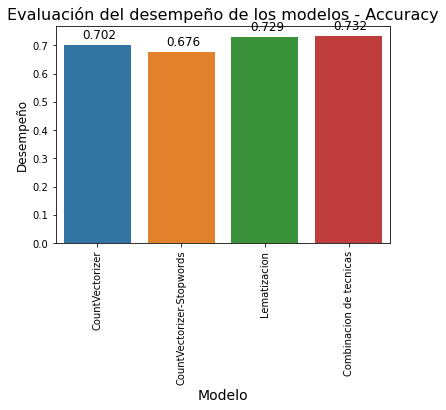

In [ ]:
# Celda 5
import seaborn as sns
import matplotlib.pyplot as plt
modelos = ['CountVectorizer','CountVectorizer-Stopwords',"Lematizacion",'Combinacion de tecnicas']
metricas = [accuracy1,accuracy2,accuracy3,accuracy4]
df = pd.DataFrame(zip(modelos,metricas), columns=['Modelo', 'Balanced accuracy']) 

plots = sns.barplot(x=modelos, y=metricas, data=df) 
  
for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.3f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=12, xytext=(2, 10), 
                   textcoords='offset points') 
    
  
plt.xlabel("Modelo", size=14) 
plt.ylabel("Desempeño", size=12)  
plt.title("Evaluación del desempeño de los modelos - Accuracy", size=16) 
plt.xticks(rotation = 90)

plt.show() 


Conclusión: 

El objetivo de hacer uso del conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter es predecir si este será positivo, neutral o negativo.

En principio y para tener una idea inicial del desempeño de los modelos, se implementaron los modelos sin profundizar en el análisis de los datos. Esto nos arrojó desempeños entre el 0.63 y 0.65. 

Teniendo en cuenta que nos encontramos ante un problema de clasificación, antes de continuar con la implementación de técnicas y modelos se balanceron las clases haciendo uso de UnderSampling, lo cual redujo las mismas a tal punto que quedaron todas con la misma cantidad de entradas. 

Encontramos valioso dentro del proceso profundizar en el análisis y limpieza de los datos, eliminando caracteres especiales, tales como números, URL, emojis, convirtiendo el texto a minúsculas y quitando los espacios en blanco que hay tanto al inicio como al final del texto. 

Después de esto haciendo hace uso la técnica de CountVectorizer, se implementaron los modelos. Hecho esto y ajustando los parámetros indicados se estimó el accuracy para cada uno de los modelos, encotrando así que el que presenta un mejor desempeño es el modelo que implementa diferentes combinaciones de técnicas, tales como CountVectorizer, eliminación de stopwords y lematización de verbos.

Las ventajas de este mejor modelo es precisamente la combinación de técnicas pues elimina la lista de palabras en el idioma inglés que no aportan en gran medida al análisis, y además la lematización realiza un análisis morfológico a las palabras, con el objetivo de eliminar solo las terminaciones flexivas y devolver la forma base o de diccionario de una palabra, lo cual reduce el número de tokens y mejorando el proceso de modelación. Un paso adicional que se sugiere y que no es posible lograr con estas técnicas es la eliminación de tokens propios del tipo de información, en este caso el tipo de avión del que se refiere el tweet (ej. a320) o el número de vuelo (ej. aa1457). Esto ayudaría a reducir el número de tokens de los diccionarios

Con respecto a la mayor desventaja a la eliminación de stopwords, es como se mencionó anteriormente ,se pueden eliminar tokens relevantes que pueden cambiar el sentido de los textos, en nuestro caso las negaciones.
